# Load graph

In [1]:
import networkx as nx
import pandas as pd
import json


edges_data = pd.read_csv('lastfm_asia_edges.csv')

labels_data = pd.read_csv('lastfm_asia_target.csv')
# with open('/Users/xielinni/Desktop/MSBD5008/project/dataset/lastfm_asia_features.json', 'r') as f:
with open('lastfm_asia_features.json', 'r') as f:
    features_data = json.load(f)

graph = nx.Graph()

# add nodes to the graph
for node_id in labels_data['id']:
    graph.add_node(node_id)

# add labels to the graph
for _, row in labels_data.iterrows():
    node_id = row['id']
    label = row['target']
    graph.nodes[node_id]['target'] = label

# add edges to the graph
for _, edge in edges_data.iterrows():
    source = edge['node_1']
    target = edge['node_2']
    graph.add_edge(source, target)

# add features to the graph
for node_id, features in features_data.items():
    node_id = int(node_id)
    graph.nodes[node_id]['features'] = features


# Multinominal Node Classification

### preprocessing: masks, labels, features

In [2]:
# !pip install  dgl -f https://data.dgl.ai/wheels/cu121/repo.html
import dgl
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
g = dgl.from_networkx(graph)

train_mask = np.zeros(len(graph), dtype=bool)
train_mask[:int(len(train_mask)*0.6)] = True
val_mask = np.zeros(len(graph), dtype=bool)
val_mask[int(len(train_mask)*0.6):int(len(val_mask)*0.8)] = True
test_mask = np.zeros(len(graph), dtype=bool)
test_mask[int(len(test_mask)*0.8):] = True
# same_indices = np.where(test_mask == val_mask)[0]
# print(same_indices)

labels = torch.tensor(labels_data['target'])
unique_values, counts = np.unique(labels, return_counts=True)
num_classes = len(unique_values)

In [4]:
# naive feat: 1 for all nodes
naive_feat = torch.unsqueeze(torch.tensor(np.ones(len(graph)), dtype=torch.float), dim=1)

# property feat: degree, clustering coefficient, eigenvector centrality for each node
degree_sequence = [graph.degree(node) for node in graph.nodes()]
clustering_coefficients = nx.clustering(graph)
clustering_coefficients = [clustering_coefficients[n] for n in graph.nodes()]
eigenvector_centrality = nx.eigenvector_centrality(graph)
eigenvector_centrality = [eigenvector_centrality[n] for n in graph.nodes()]
property_feat = torch.tensor([
    [degree_sequence[i], clustering_coefficients[i], eigenvector_centrality[i]]
    for i in range(len(graph))
])

In [5]:
#real features
max_feature = max(max(lst) for lst in features_data.values() if lst)

feat = torch.zeros(len(graph), max_feature+1, dtype=torch.bool)
for i, lst in enumerate(features_data.values()):
  if lst:
    feat[i, lst] = True
cols_to_remove = torch.all(feat == False, dim=0)
cols_to_keep = ~cols_to_remove
feat = feat[:, cols_to_keep]
feat = feat.float()
feat.shape

torch.Size([7624, 7842])

### build the GNN and training function

In [6]:
from dgl.nn import SAGEConv

class GNN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

In [7]:
def train(g,model,features, epochs=100):
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    best_embeddings = []

    statistic = {
        'loss': [],
        'train_acc': [],
        'val_acc': [],
    }

    for e in range(epochs):
        # Forward
        logits, embeddings = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        #Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        # test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save loss , val_acc and test_acc
        statistic['loss'].append(loss)
        statistic['train_acc'].append(train_acc)
        statistic['val_acc'].append(val_acc)
        # statistic['test_acc'].append(test_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
            best_embeddings = embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")

    return best_val_acc, best_test_acc, best_embeddings, statistic

### train the models

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device is :', device)

hidden_dim = 16
epochs = 500

print(torch.version.cuda)
print(torch.__version__)
g = g.to(device)
labels = labels.to(device)

device is : cuda
12.1
2.1.2


In [9]:
import matplotlib.pyplot as plt

def train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs=100):
    model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_embeddings, info = train(graph, model, feat, epochs)
    return best_val_acc, best_test_acc, best_embeddings, info


def plot_statistics(statistics):
  # plot the loss

  loss_values = [loss.item() for loss in statistics['loss']]

  plt.figure()
  plt.plot(loss_values, label='loss')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.show()

  # plot validation accuracy and test accuracy in the same figure

  train_values = [acc.item() for acc in statistics['train_acc']]
  val_values = [acc.item() for acc in statistics['val_acc']]

  plt.figure()
  plt.plot(train_values, label='train acc')
  plt.plot(val_values, label='val acc')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.show()

def train_wrapper(ModelClass, feat, hidden_dim, num_classes, graph, epochs=100):
    best_val_acc, best_test_acc, best_embeddings, info = train_model(ModelClass, feat, hidden_dim, num_classes, graph, epochs)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    return best_embeddings


#### naive model with features all 1

In epoch 0, loss: 2.842, val acc: 0.209 (best 0.209, best 0.201)
In epoch 50, loss: 2.365, val acc: 0.209 (best 0.209, best 0.201)
In epoch 100, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 150, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 200, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 250, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 300, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 350, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 400, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)
In epoch 450, loss: 2.364, val acc: 0.209 (best 0.209, best 0.201)


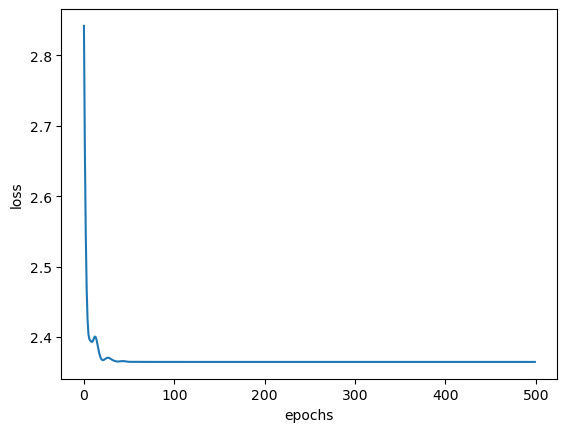

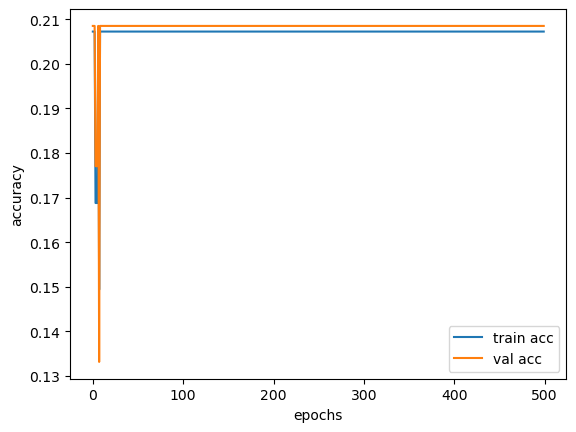

Best val acc: 0.209, best test acc: 0.201


In [10]:
best_embeddings_naive = train_wrapper(GNN, naive_feat, hidden_dim, num_classes, g, epochs)

#### model with features being properties

In epoch 0, loss: 18.226, val acc: 0.010 (best 0.010, best 0.006)
In epoch 50, loss: 2.334, val acc: 0.224 (best 0.228, best 0.222)
In epoch 100, loss: 2.227, val acc: 0.252 (best 0.257, best 0.248)
In epoch 150, loss: 2.176, val acc: 0.266 (best 0.266, best 0.262)
In epoch 200, loss: 2.139, val acc: 0.276 (best 0.276, best 0.275)
In epoch 250, loss: 2.103, val acc: 0.280 (best 0.282, best 0.280)
In epoch 300, loss: 2.063, val acc: 0.303 (best 0.304, best 0.313)
In epoch 350, loss: 2.019, val acc: 0.325 (best 0.325, best 0.327)
In epoch 400, loss: 1.975, val acc: 0.345 (best 0.345, best 0.334)
In epoch 450, loss: 1.934, val acc: 0.352 (best 0.357, best 0.344)


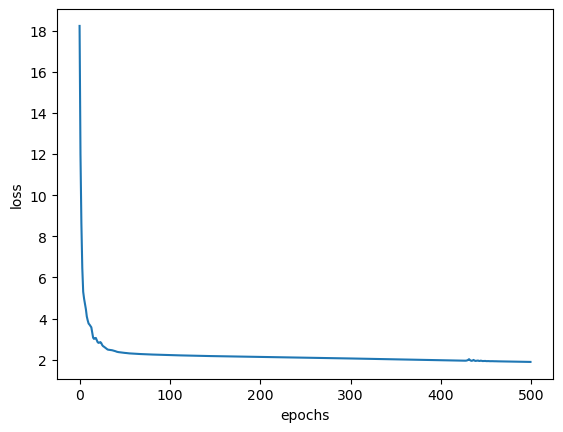

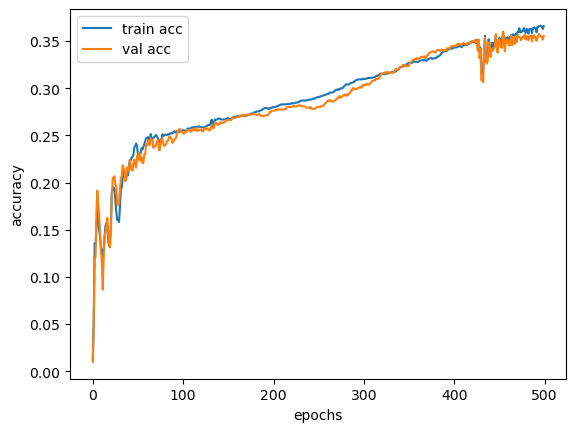

Best val acc: 0.360, best test acc: 0.349


In [11]:
# property_model = GNN(property_feat.shape[1], hidden_dim, num_classes).to(device)
# property_feat = property_feat.to(device)
# best_val_acc, best_test_acc, best_embeddings_property = train(g, property_model, property_feat)

property_feat_embedding = train_wrapper(GNN, property_feat, hidden_dim, num_classes, g, epochs)

#### model with real features

In epoch 0, loss: 2.922, val acc: 0.165 (best 0.165, best 0.159)
In epoch 50, loss: 0.604, val acc: 0.725 (best 0.725, best 0.727)
In epoch 100, loss: 0.119, val acc: 0.790 (best 0.790, best 0.786)
In epoch 150, loss: 0.024, val acc: 0.796 (best 0.797, best 0.793)
In epoch 200, loss: 0.009, val acc: 0.799 (best 0.799, best 0.790)
In epoch 250, loss: 0.005, val acc: 0.798 (best 0.801, best 0.789)
In epoch 300, loss: 0.003, val acc: 0.799 (best 0.801, best 0.789)
In epoch 350, loss: 0.002, val acc: 0.797 (best 0.801, best 0.789)
In epoch 400, loss: 0.001, val acc: 0.797 (best 0.801, best 0.789)
In epoch 450, loss: 0.001, val acc: 0.796 (best 0.801, best 0.789)


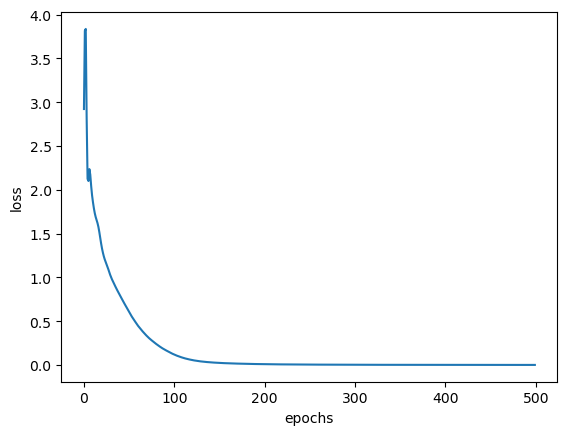

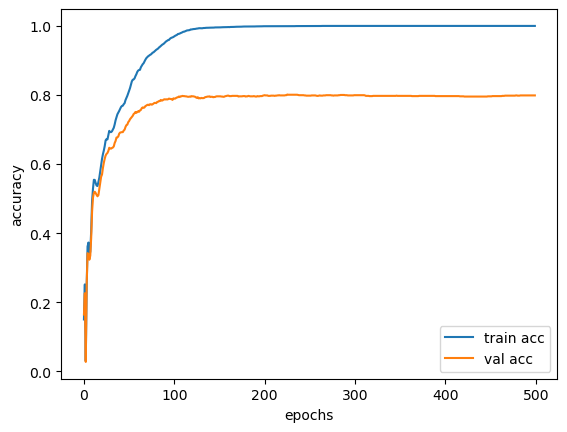

Best val acc: 0.801, best test acc: 0.789


In [12]:
real_feat_embedding = train_wrapper(GNN, feat, hidden_dim, num_classes, g, epochs)

### change the number of layers of the model

In [13]:
class GNNrepeat(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, repeat_time):
        super(GNNrepeat, self).__init__()
        self.repeat_time = repeat_time
        
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.linear = nn.Linear(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        for i in range(self.repeat_time-2):
            h = self.conv2(g, h)
            h = F.relu(h)
        h = self.conv2(g, h)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

#### layer = 5

In epoch 0, loss: 5.784, val acc: 0.033 (best 0.033, best 0.042)
In epoch 50, loss: 1.093, val acc: 0.690 (best 0.690, best 0.653)
In epoch 100, loss: 0.684, val acc: 0.778 (best 0.780, best 0.776)
In epoch 150, loss: 0.449, val acc: 0.811 (best 0.811, best 0.814)
In epoch 200, loss: 0.307, val acc: 0.809 (best 0.814, best 0.819)
In epoch 250, loss: 1.713, val acc: 0.466 (best 0.814, best 0.819)
In epoch 300, loss: 0.597, val acc: 0.720 (best 0.814, best 0.819)
In epoch 350, loss: 0.391, val acc: 0.760 (best 0.814, best 0.819)
In epoch 400, loss: 0.273, val acc: 0.776 (best 0.814, best 0.819)
In epoch 450, loss: 0.194, val acc: 0.784 (best 0.814, best 0.819)


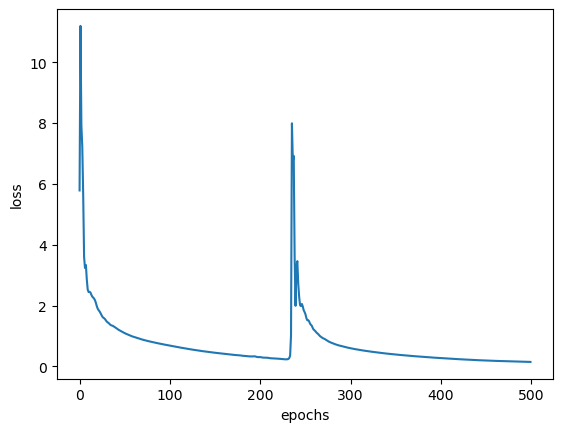

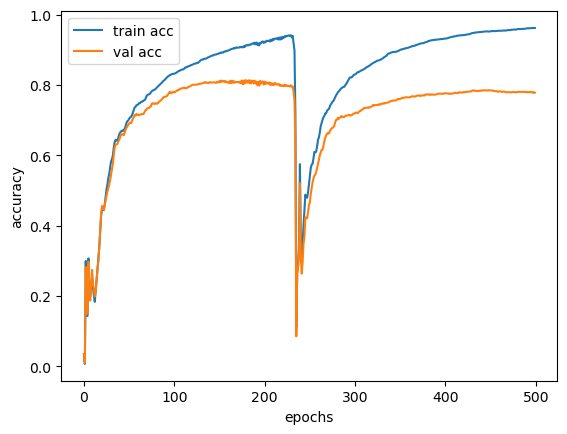

Best val acc: 0.814, best test acc: 0.819


In [14]:
class GNN5(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN5, self).__init__(in_feats, h_feats, num_classes, 5)

GNN5_embedding = train_wrapper(GNN5, feat, hidden_dim, num_classes, g, epochs)



#### layer = 10

In epoch 0, loss: 4.364, val acc: 0.043 (best 0.043, best 0.033)
In epoch 50, loss: 1.434, val acc: 0.550 (best 0.550, best 0.534)
In epoch 100, loss: 1.051, val acc: 0.652 (best 0.738, best 0.749)
In epoch 150, loss: 0.596, val acc: 0.807 (best 0.807, best 0.819)
In epoch 200, loss: 1.413, val acc: 0.474 (best 0.812, best 0.828)
In epoch 250, loss: 0.505, val acc: 0.813 (best 0.813, best 0.814)
In epoch 300, loss: 0.402, val acc: 0.813 (best 0.817, best 0.818)
In epoch 350, loss: 0.342, val acc: 0.808 (best 0.817, best 0.818)
In epoch 400, loss: 2.919, val acc: 0.130 (best 0.817, best 0.818)
In epoch 450, loss: 1.490, val acc: 0.504 (best 0.817, best 0.818)


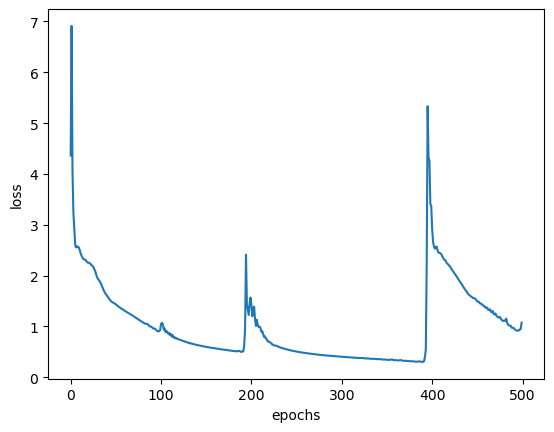

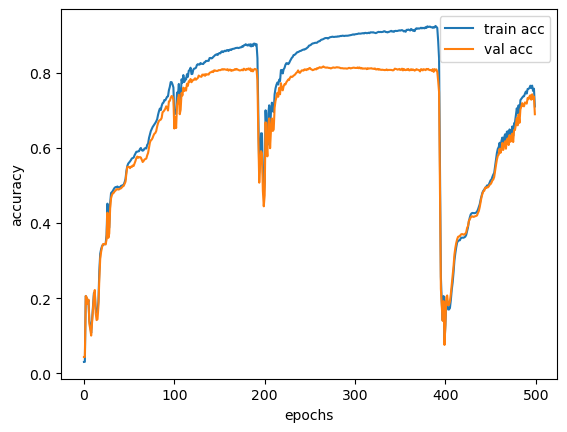

Best val acc: 0.817, best test acc: 0.818


In [15]:
class GNN10(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN10, self).__init__(in_feats, h_feats, num_classes, 10)
        
GNN10_embedding = train_wrapper(GNN10, feat, hidden_dim, num_classes, g, epochs)

#### layer = 15

In epoch 0, loss: 2.959, val acc: 0.010 (best 0.010, best 0.014)
In epoch 50, loss: 1.363, val acc: 0.542 (best 0.542, best 0.537)
In epoch 100, loss: 1.364, val acc: 0.563 (best 0.570, best 0.555)
In epoch 150, loss: 0.909, val acc: 0.679 (best 0.679, best 0.658)
In epoch 200, loss: 0.618, val acc: 0.732 (best 0.735, best 0.727)
In epoch 250, loss: 0.456, val acc: 0.762 (best 0.767, best 0.772)
In epoch 300, loss: 0.416, val acc: 0.774 (best 0.776, best 0.784)
In epoch 350, loss: 3.571, val acc: 0.123 (best 0.787, best 0.801)
In epoch 400, loss: 1.589, val acc: 0.501 (best 0.787, best 0.801)
In epoch 450, loss: 1.028, val acc: 0.681 (best 0.787, best 0.801)


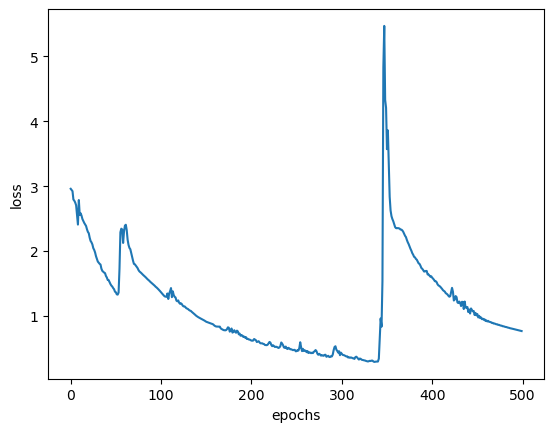

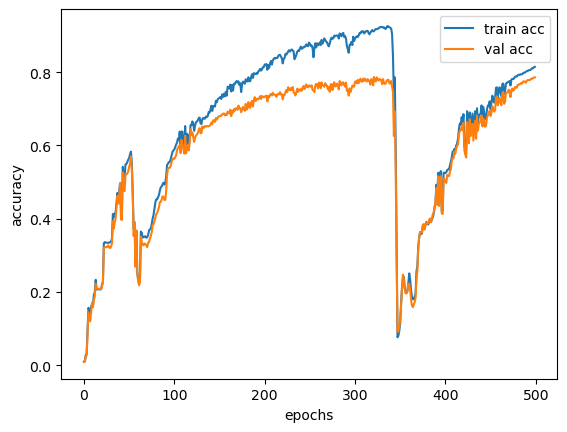

Best val acc: 0.787, best test acc: 0.801


In [16]:
class GNN15(GNNrepeat):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GNN15, self).__init__(in_feats, h_feats, num_classes, 15)
        
GNN15_embedding = train_wrapper(GNN15, feat, hidden_dim, num_classes, g, epochs)

### Transductive vs Inductive

#### seperate subgraphs and redefine training function

In [17]:
train_graph = dgl.node_subgraph(g, torch.tensor(train_mask))
val_graph = dgl.node_subgraph(g, torch.tensor(val_mask))
test_graph = dgl.node_subgraph(g, torch.tensor(test_mask))

In [18]:
# seperately train 3 graphs.
def train_in(train_graph, val_graph, test_graph, model, feat, epochs=100):
    optimizer=torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0
    best_train_embeddings = []
    best_val_embeddings = []
    best_test_embeddings = []
    
    statistics = {
        'loss': [],
        'train_acc': [],
        'val_acc': [],
    }

    for e in range(epochs):
        # Forward
        train_logits, train_embeddings = model(train_graph, feat[train_mask])
        val_logits, val_embeddings = model(val_graph, feat[val_mask])
        # test_logits, test_embeddings = model(test_graph, real_feat[test_mask])

        # Compute prediction
        train_pred = train_logits.argmax(1)
        val_pred = val_logits.argmax(1)
        # test_pred = test_logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(train_logits, labels[train_mask])

        #Compute accuracy on training/validation/test
        train_acc = (train_pred == labels[train_mask]).float().mean()
        val_acc = (val_pred == labels[val_mask]).float().mean()
        # test_acc = (test_pred == labels[test_mask]).float().mean()
        
        statistics['loss'].append(loss)
        statistics['train_acc'].append(train_acc)
        statistics['val_acc'].append(val_acc)

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc

            test_logits, test_embeddings = model(test_graph, feat[test_mask])
            test_pred = test_logits.argmax(1)
            best_test_acc = (test_pred == labels[test_mask]).float().mean()

            best_train_embeddings = train_embeddings
            best_val_embeddings = val_embeddings
            best_test_embeddings = test_embeddings

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % (epochs // 10) == 0:
            print(f"In epoch {e}, loss: {loss:.3f}, val acc: {val_acc:.3f} (best {best_val_acc:.3f}, best {best_test_acc:.3f})")

    return best_val_acc, best_test_acc, best_train_embeddings, best_val_embeddings, best_test_embeddings, statistics

#### train model

In [19]:
def train_in_wrapper(ModelClass, feat, hidden_dim, num_classes, train_graph, val_graph, test_graph, epochs=100):
    in_model = ModelClass(feat.shape[1], hidden_dim, num_classes).to(device)
    feat = feat.to(device)
    best_val_acc, best_test_acc, best_train_embeddings, best_val_embeddings, best_test_embeddings, info = train_in(train_graph, val_graph, test_graph, in_model, feat, epochs)
    plot_statistics(info)
    print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
    
    best_embeddings = {
        'train': best_train_embeddings,
        'val': best_val_embeddings,
        'test': best_test_embeddings
    }
    
    return best_embeddings


In epoch 0, loss: 3.082, val acc: 0.029 (best 0.029, best 0.020)
In epoch 50, loss: 0.241, val acc: 0.681 (best 0.681, best 0.667)
In epoch 100, loss: 0.067, val acc: 0.696 (best 0.702, best 0.679)
In epoch 150, loss: 0.035, val acc: 0.699 (best 0.702, best 0.679)
In epoch 200, loss: 0.026, val acc: 0.692 (best 0.702, best 0.679)
In epoch 250, loss: 0.021, val acc: 0.693 (best 0.702, best 0.679)
In epoch 300, loss: 0.018, val acc: 0.692 (best 0.702, best 0.679)
In epoch 350, loss: 0.015, val acc: 0.694 (best 0.702, best 0.679)
In epoch 400, loss: 0.014, val acc: 0.693 (best 0.702, best 0.679)
In epoch 450, loss: 0.013, val acc: 0.692 (best 0.702, best 0.679)


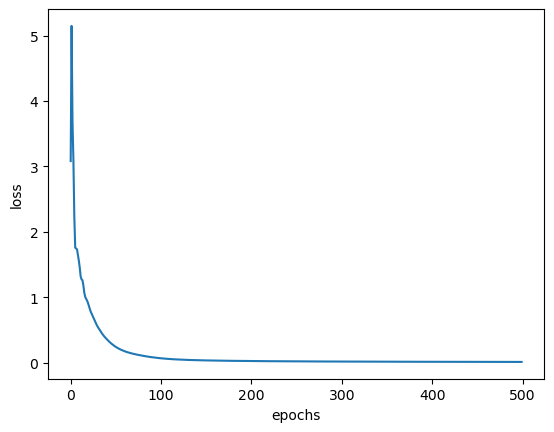

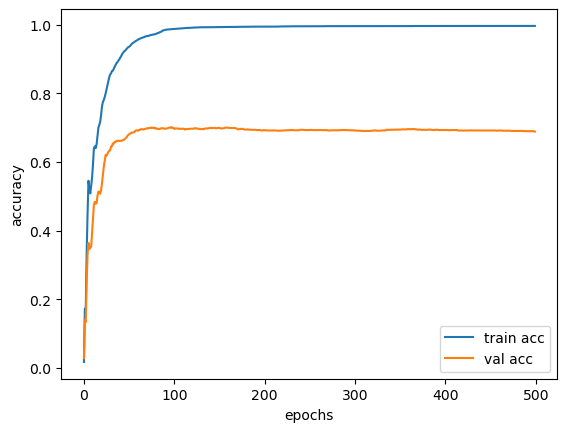

Best val acc: 0.702, best test acc: 0.679


In [20]:
# in_model = GNN(real_feat.shape[1], hidden_dim, num_classes).to(device)
# best_val_acc, best_test_acc, best_train_embeddings, best_val_embeddings, best_test_embeddings = train_in(train_graph, val_graph, test_graph, in_model)
GNN_in_embeddings = train_in_wrapper(GNN, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs)

#### change layer: 5

In epoch 0, loss: 3.411, val acc: 0.051 (best 0.051, best 0.052)
In epoch 50, loss: 1.219, val acc: 0.465 (best 0.465, best 0.479)
In epoch 100, loss: 0.702, val acc: 0.518 (best 0.519, best 0.506)
In epoch 150, loss: 3.150, val acc: 0.400 (best 0.522, best 0.500)
In epoch 200, loss: 0.603, val acc: 0.540 (best 0.547, best 0.535)
In epoch 250, loss: 0.415, val acc: 0.542 (best 0.550, best 0.564)
In epoch 300, loss: 0.323, val acc: 0.550 (best 0.554, best 0.554)
In epoch 350, loss: 0.258, val acc: 0.548 (best 0.555, best 0.550)
In epoch 400, loss: 0.221, val acc: 0.519 (best 0.555, best 0.550)
In epoch 450, loss: 0.186, val acc: 0.511 (best 0.555, best 0.550)


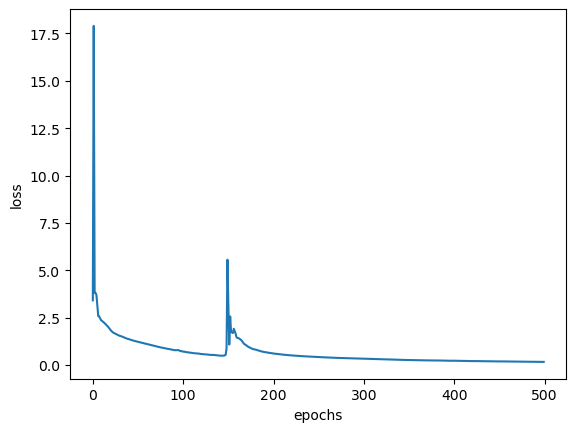

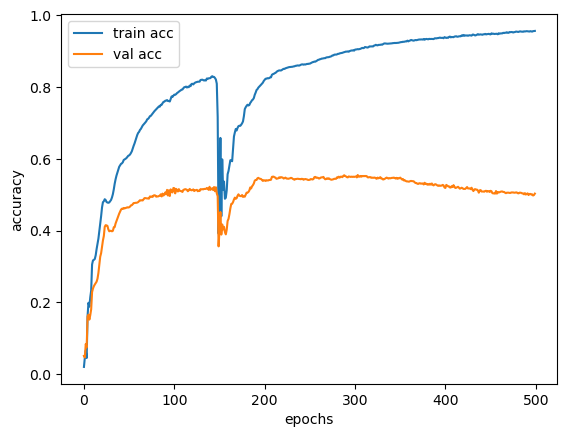

Best val acc: 0.555, best test acc: 0.550


In [21]:


# repeat_time = 5
# repeat_in_model_5 = GNNrepeat(real_feat.shape[1], hidden_dim, num_classes, repeat_time).to(device)
# best_val_acc, best_test_acc, best_train_embeddings_5, best_val_embeddings_5, best_test_embeddings_5 = train_in(train_graph, val_graph, test_graph, in_model)

GNN5_in_embeddings = train_in_wrapper(GNN5, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs)

#### layer = 10

In epoch 0, loss: 3.161, val acc: 0.035 (best 0.035, best 0.016)
In epoch 50, loss: 2.229, val acc: 0.283 (best 0.283, best 0.311)
In epoch 100, loss: 1.620, val acc: 0.433 (best 0.433, best 0.428)
In epoch 150, loss: 1.341, val acc: 0.468 (best 0.487, best 0.492)
In epoch 200, loss: 0.830, val acc: 0.510 (best 0.538, best 0.513)
In epoch 250, loss: 1.245, val acc: 0.478 (best 0.538, best 0.513)
In epoch 300, loss: 0.607, val acc: 0.497 (best 0.538, best 0.513)
In epoch 350, loss: 0.473, val acc: 0.453 (best 0.538, best 0.513)
In epoch 400, loss: 0.413, val acc: 0.445 (best 0.538, best 0.513)
In epoch 450, loss: 0.349, val acc: 0.446 (best 0.538, best 0.513)


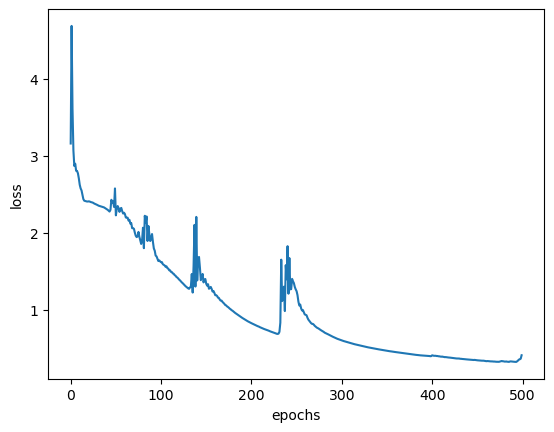

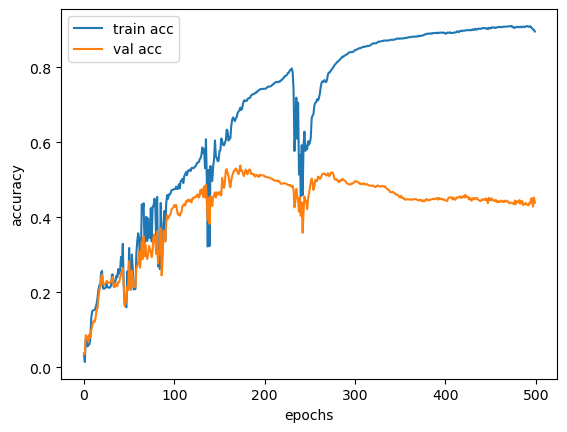

Best val acc: 0.538, best test acc: 0.513


In [22]:
GNN10_in_embeddings = train_in_wrapper(GNN10, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs)

#### layer = 15

In epoch 0, loss: 69.635, val acc: 0.033 (best 0.033, best 0.030)
In epoch 50, loss: 2.550, val acc: 0.127 (best 0.157, best 0.110)
In epoch 100, loss: 2.199, val acc: 0.241 (best 0.242, best 0.256)
In epoch 150, loss: 2.051, val acc: 0.244 (best 0.258, best 0.257)
In epoch 200, loss: 1.952, val acc: 0.261 (best 0.262, best 0.272)
In epoch 250, loss: 1.863, val acc: 0.243 (best 0.290, best 0.318)
In epoch 300, loss: 1.734, val acc: 0.266 (best 0.290, best 0.318)
In epoch 350, loss: 1.629, val acc: 0.287 (best 0.298, best 0.290)
In epoch 400, loss: 1.542, val acc: 0.279 (best 0.320, best 0.292)
In epoch 450, loss: 1.664, val acc: 0.293 (best 0.320, best 0.292)


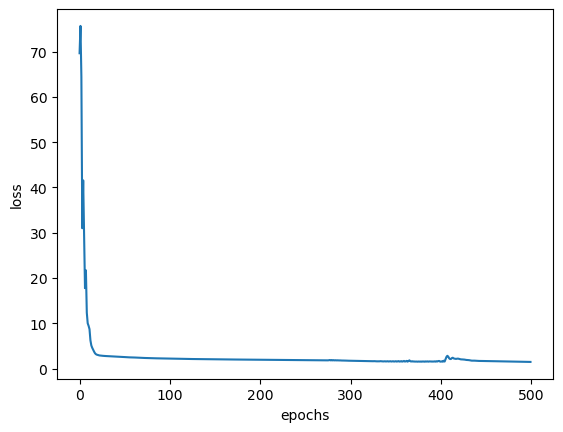

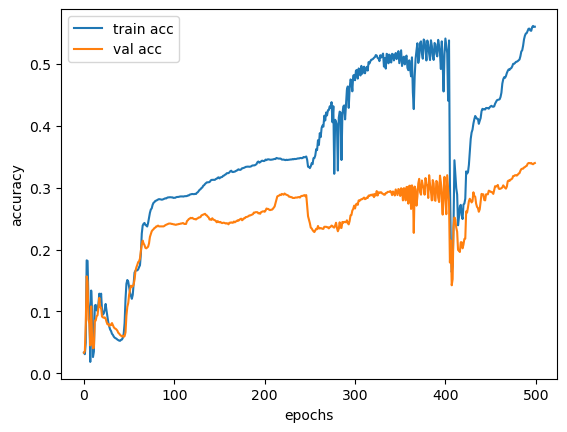

Best val acc: 0.340, best test acc: 0.346


In [23]:
GNN15_in_embeddings = train_in_wrapper(GNN15, feat, hidden_dim, num_classes,train_graph, val_graph, test_graph, epochs)

## Graph Transformer

### build a Graphormer model

In [24]:
from dgl.nn import GraphormerLayer

class Graphormer(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(Graphormer, self).__init__()
        self.conv1 = GraphormerLayer(in_feats, h_feats, num_heads=8)
        self.conv2 = GraphormerLayer(in_feats, h_feats, num_heads=8)
        self.linear = nn.Linear(in_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(in_feat)
        h = F.relu(h)
        h = self.conv2(h)
        h = h.squeeze(0)
        embeddings = h
        h = self.linear(h)
        return h, embeddings

#### transform features: compressing dimensionality to 128

In [25]:
from sklearn.decomposition import PCA

def pca_compressing(real_feat, traget_components=128):
  pca = PCA(n_components=traget_components)
  real_feat_pca = pca.fit_transform(real_feat.cpu().detach().numpy())
  real_feat_pca = torch.tensor(real_feat_pca).float().unsqueeze(0).to(device)
  return real_feat_pca


#### train the model

In [26]:
def train_graphormer_wrapper(ModelClass, real_feat, hidden_dim, num_classes, graph, traget_components, epochs=100):
  real_feat_pca = pca_compressing(real_feat, traget_components)
  graphormer = ModelClass(real_feat_pca.shape[2], hidden_dim, num_classes).to(device)
  best_val_acc, best_test_acc, best_embeddings_graphormer, info = train(graph, graphormer, real_feat_pca, epochs)
  plot_statistics(info)
  print(f"Best val acc: {best_val_acc:.3f}, best test acc: {best_test_acc:.3f}")
  return best_embeddings_graphormer


In [27]:
hidden_size = 32

In epoch 0, loss: 3.049, val acc: 0.047 (best 0.047, best 0.044)
In epoch 1, loss: 2.503, val acc: 0.235 (best 0.235, best 0.226)
In epoch 2, loss: 2.719, val acc: 0.134 (best 0.235, best 0.226)
In epoch 3, loss: 2.495, val acc: 0.243 (best 0.243, best 0.226)
In epoch 4, loss: 2.334, val acc: 0.376 (best 0.376, best 0.344)
In epoch 5, loss: 2.246, val acc: 0.307 (best 0.376, best 0.344)
In epoch 6, loss: 2.144, val acc: 0.346 (best 0.376, best 0.344)
In epoch 7, loss: 1.951, val acc: 0.441 (best 0.441, best 0.443)
In epoch 8, loss: 1.795, val acc: 0.481 (best 0.481, best 0.485)
In epoch 9, loss: 1.602, val acc: 0.551 (best 0.551, best 0.556)


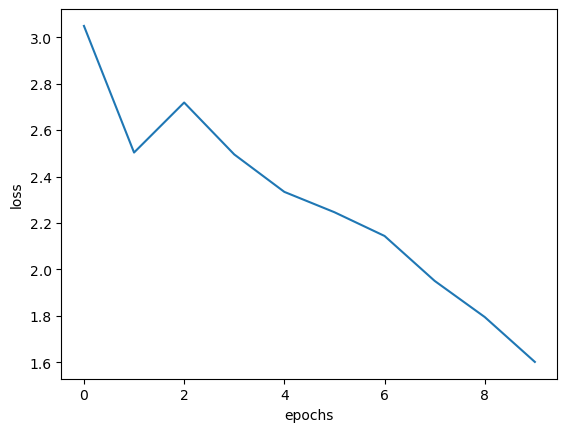

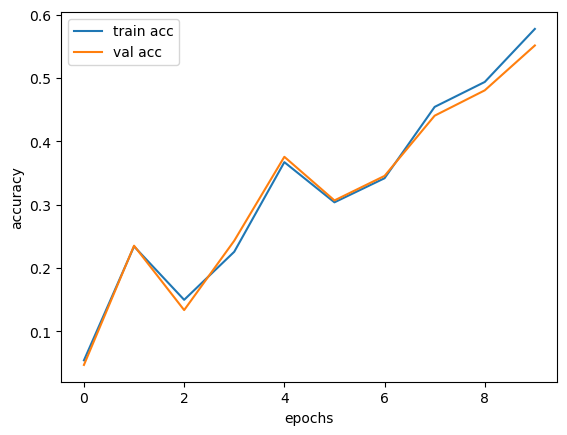

Best val acc: 0.551, best test acc: 0.556


In [28]:

# graphormer = Graphormer(real_feat_pca.shape[2], hidden_size, num_classes).to(device)
# best_val_acc, best_test_acc, best_embeddings_graphormer = train(g, graphormer, real_feat_pca, epochs=10)

Graphormer128_embeddings = train_graphormer_wrapper(Graphormer, feat, hidden_size, num_classes, g, traget_components=128, epochs=10)



#### another test on dimension 32

In epoch 0, loss: 2.978, val acc: 0.058 (best 0.058, best 0.068)
In epoch 1, loss: 2.506, val acc: 0.265 (best 0.265, best 0.268)
In epoch 2, loss: 2.312, val acc: 0.349 (best 0.349, best 0.355)
In epoch 3, loss: 2.214, val acc: 0.386 (best 0.386, best 0.380)
In epoch 4, loss: 2.140, val acc: 0.400 (best 0.400, best 0.397)
In epoch 5, loss: 2.054, val acc: 0.433 (best 0.433, best 0.427)
In epoch 6, loss: 1.958, val acc: 0.461 (best 0.461, best 0.465)
In epoch 7, loss: 1.848, val acc: 0.501 (best 0.501, best 0.482)
In epoch 8, loss: 1.737, val acc: 0.540 (best 0.540, best 0.514)
In epoch 9, loss: 1.631, val acc: 0.559 (best 0.559, best 0.531)


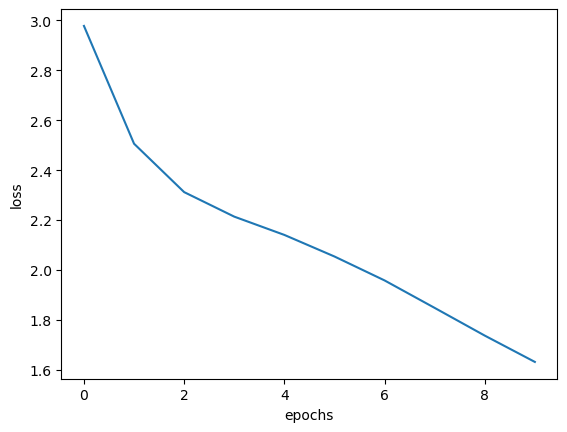

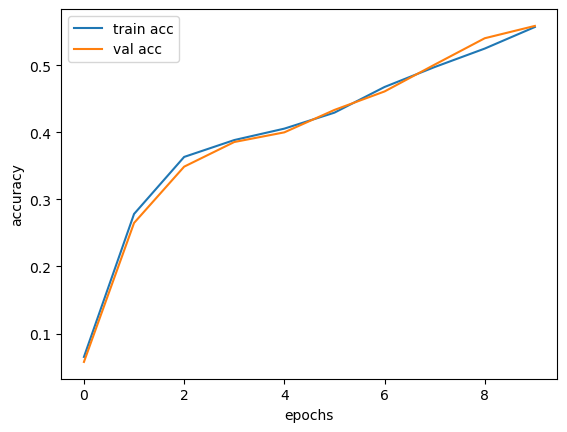

Best val acc: 0.559, best test acc: 0.531


In [29]:
Graphormer32_embeddings = train_graphormer_wrapper(Graphormer, feat, hidden_size, num_classes, g, traget_components=32, epochs=10)

## visualize the embedding features

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_embeddings(embeddings, labels):
  labels = labels.cpu()
  embeddings = embeddings.cpu().detach().numpy()
  tsne = TSNE().fit_transform(embeddings)
  plt.scatter(tsne[:, 0], tsne[:, 1], c=labels)


In [ ]:
# plot_embeddings(best_embeddings_naive, labels)

In [ ]:
# plot_embeddings(property_feat_embedding, labels)

In [ ]:
# plot_embeddings(real_feat_embedding, labels)

In [ ]:
# plot_embeddings(GNN5_embedding, labels)

In [ ]:
# plot_embeddings(GNN10_embedding, labels)

In [ ]:
# plot_embeddings(GNN15_embedding, labels)


In [ ]:
def plot_embeddings_in(in_embeddings, labels, train_mask, val_mask, test_mask):
  train_embedding = in_embeddings['train'].cpu().detach().numpy()
  train_tsne = TSNE().fit_transform(train_embedding)
  val_embedding = in_embeddings['val'].cpu().detach().numpy()
  val_tsne = TSNE().fit_transform(val_embedding)
  test_embedding = in_embeddings['test'].cpu().detach().numpy()
  test_tsne = TSNE().fit_transform(test_embedding)

  train_labels = labels[train_mask].cpu().numpy()
  val_labels = labels[val_mask].cpu().numpy()
  test_labels = labels[test_mask].cpu().numpy()
  
  fig, axes = plt.subplots(nrows=1, ncols=3)
  axes[0].scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels)
  axes[1].scatter(val_tsne[:, 0], val_tsne[:, 1], c=val_labels)
  axes[2].scatter(test_tsne[:, 0], test_tsne[:, 1], c=test_labels)
  plt.show()

In [ ]:
# plot_embeddings_in(GNN5_in_embeddings, labels, train_mask, val_mask, test_mask)

In [ ]:
# plot_embeddings_in(GNN10_in_embeddings, labels, train_mask, val_mask, test_mask)

In [ ]:
# plot_embeddings_in(GNN15_in_embeddings, labels, train_mask, val_mask, test_mask)

In [ ]:
# plot_embeddings(Graphormer128_embeddings, labels)

In [ ]:
# plot_embeddings(Graphormer32_embeddings, labels)

###